# Point Source Tutorial

This is a quick demonstration of how to model both extended objects and point sources in the same scence. This may or may not be robust enough for crowded field photometry. We're curious about reports.

First we load a simulated image cube, for which we know which sources are galaxies and which ones are stars, so we can use the appropriate source type. In practice, this would have to be guessed and potentially revised after the first attempt.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno', interpolation='none')

import numpy as np
import scarlet
from scarlet.display import AsinhMapping

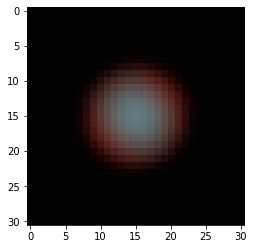

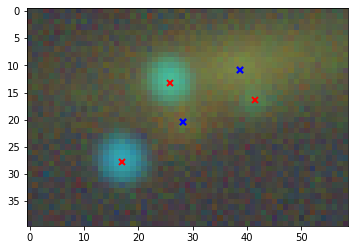

In [2]:
# Use this to point to the location of the data on your system
# Load the sample images
data = np.load("../../data/psf_unmatched_sim.npz")
images = data["images"]
filters = data["filters"]
psfs = data["psfs"]
catalog = data["catalog"]
# Estimate of the background noise level
weights = np.ones_like(images) / 2**2

# display psfs
pnorm = AsinhMapping(minimum=psfs.min(), stretch=psfs.max()/20, Q=20)
prgb = scarlet.display.img_to_rgb(psfs, norm=pnorm)
plt.imshow(prgb)
plt.show()

# Use Asinh scaling for the images
norm = AsinhMapping(minimum=images.min(), stretch=10, Q=20)
# Map i,r,g -> RGB
# Convert the image to an RGB image
img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
plt.imshow(img_rgb)
for src in catalog:
    if src["is_star"]:
        plt.plot(src["x"], src["y"], "rx", mew=2)
    else:
        plt.plot(src["x"], src["y"], "bx", mew=2)
plt.show()

## Create Frame and Observation

In [3]:
from functools import partial
model_psf = scarlet.PSF(partial(scarlet.psf.gaussian, sigma=0.9), shape=(None,31,31))
model_frame = scarlet.Frame(images.shape, psfs=model_psf, channels=filters)

observation = scarlet.Observation(images, 
                                  psfs=scarlet.PSF(psfs), 
                                  weights=weights,
                                  channels=filters)
observation = observation.match(model_frame)

## Define Sources

**You have to define what sources you want to fit.** 
Since we know which sources are stars (it's stored in the catalog), we can pick the proper source type. This is the situations e.g. *Gaia*-confirmed stars. In deeper observations or more crowded fields, additional logic will be needed (such as color priors on stars vs galaxies) to perform the star-galaxy separation.

In [4]:
# Initalize the sources
sources = []
for idx in np.unique(catalog["index"]):
    src = catalog[catalog["index"]==idx][0]
    if src["is_star"]:
        new_source = scarlet.PointSource(
            model_frame, 
            (src["y"], src["x"]),
            observation
        )
    else:
        new_source = scarlet.ExtendedSource(
            model_frame,
           (src["y"], src["x"]),
            observation,
        )
    sources.append(new_source)

## Create Blend

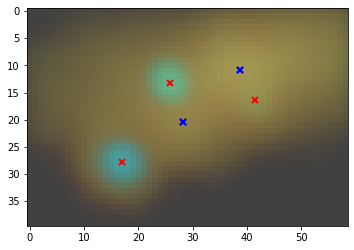

In [5]:
# Initialize the Blend object, which later fits the model
blend = scarlet.Blend(sources, observation)

# Display the initial model
model = blend.get_model()
model_ = observation.render(model)
img_rgb = scarlet.display.img_to_rgb(model_, norm=norm)
plt.imshow(img_rgb)
for src in catalog:
    if src["is_star"]:
        plt.plot(src["x"], src["y"], "rx", mew=2)
    else:
        plt.plot(src["x"], src["y"], "bx", mew=2)
plt.show()

Our three stars (the red x's) are initialized to match their peak value with the peak of the image while the extended sources are initialized in the usual way. Note that the star centers may be a bit off, but this will be corrected by recentering them during the fit.

## Fit Model and Display Results

CPU times: user 2.26 s, sys: 7.69 ms, total: 2.27 s
Wall time: 2.27 s
scarlet ran for 100 iterations to logL = -140232.51093975367


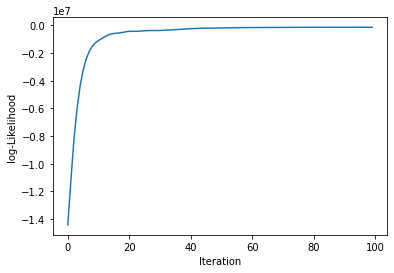

In [6]:
%time it, logL = blend.fit(100, e_rel=1e-4)
print(f"scarlet ran for {it} iterations to logL = {logL}")
scarlet.display.show_likelihood(blend)
plt.show()

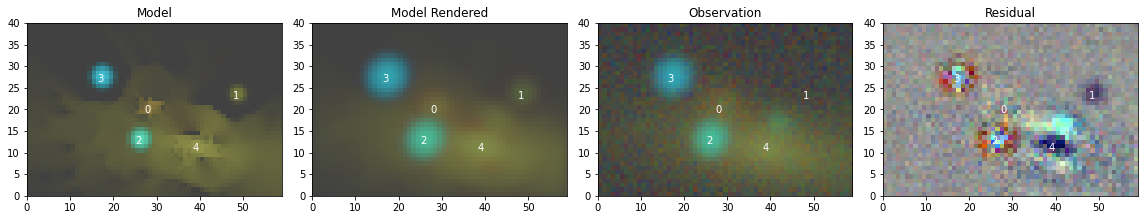

In [7]:
scarlet.display.show_scene(sources, 
                           norm=norm, 
                           observation=observation, 
                           show_rendered=True, 
                           show_observed=True, 
                           show_residual=True)
plt.show()

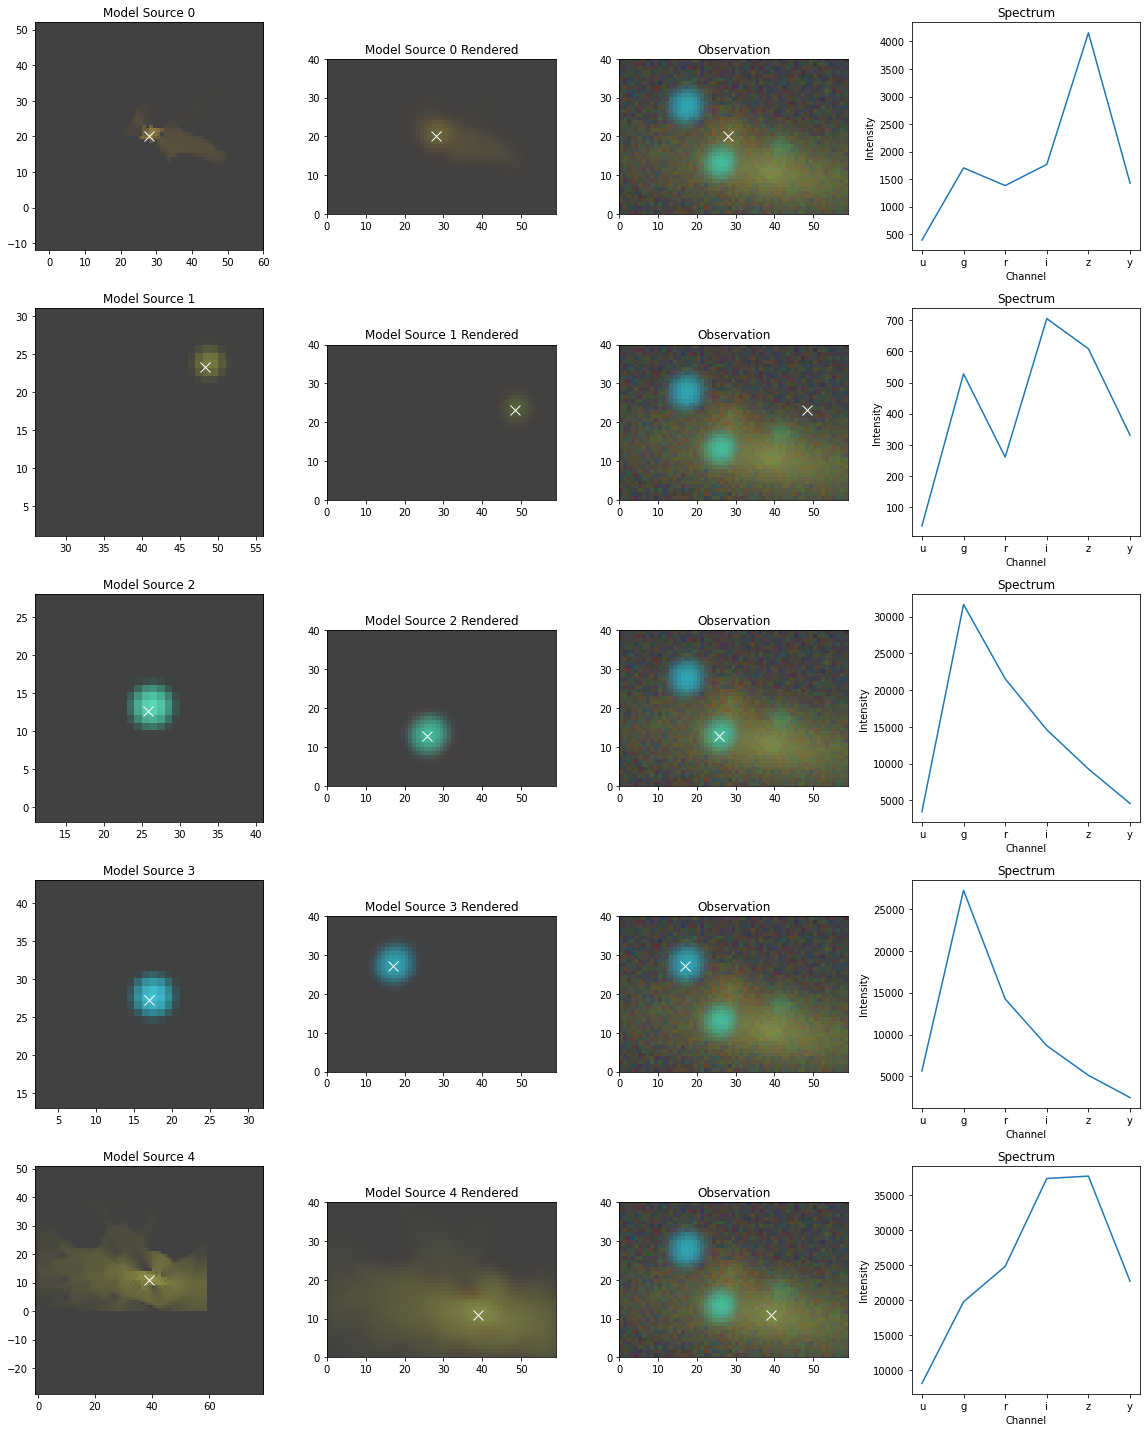

In [8]:
scarlet.display.show_sources(sources, 
                             norm=norm, 
                             observation=observation,
                             show_rendered=True, 
                             show_observed=True)
plt.show()

We can see that the model overall performs well, especially in fitting the amplitude and locations of the point sources. It is worth noting that the stellar residuals have red rings and blue cores, which suggest that the PSF model of the observation is not quite correct across all bands. The extended sources are less convincing. The effects of the symmetry constraint are clearly visible, and the color between the two galaxies is not very different, so these two sources remain poorly separated.